In [1]:
import warnings
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import ast
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4]

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'


In [2]:
# colors
class Colors:

    yale_blue = "#033270"
    green_blue = "#1368aa"
    celestial_blue = "#4091c9"
    light_blue = "#9dcee2"
    misty_rose = "#fedfd4"
    salmon = "#f29479"
    tomato = "#f26a4f"
    vermilion = "#ef3c2d"
    engineering_orange = "#cb1b16"
    rosewood = "#65010c"

In [3]:
import sqlquery

events_1819 = sqlquery.events_1819
events_1920 = sqlquery.events_1920
events_2021 = sqlquery.events_2021

your 131072x1 screen size is bogus. expect trouble
23/12/15 16:42:44 WARN Utils: Your hostname, LAPTOP-K2AN2JOP resolves to a loopback address: 127.0.1.1; using 172.20.195.27 instead (on interface eth0)
23/12/15 16:42:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/15 16:42:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


connecting to database...


Loading class `com.mysql.jdbc.Driver'. This is deprecated. The new driver class is `com.mysql.cj.jdbc.Driver'. The driver is automatically registered via the SPI and manual loading of the driver class is generally unnecessary.
23/12/15 16:42:52 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


fetching data...


In [4]:
from eventstox import events_to_df

df_1819 = events_to_df(events_1819)
df_1920 = events_to_df(events_1920)
df_2021 = events_to_df(events_2021)

In [5]:
df_1819.to_csv('df_1819.csv', index=False)
df_1920.to_csv('df_1920.csv', index=False)
df_2021.to_csv('df_2021.csv', index=False)

In [20]:
from eventstox import df_to_X_y

df = pd.concat([df_1819, df_1920], axis=0)
X, y = df_to_X_y(df)

In [24]:
# remove outliers
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from models import encode_standardize


def outlier_removal(X: pd.DataFrame, y: np.array):

    X_scaled = encode_standardize(X)

    # model = KNN(contamination=0.05, n_neighbors=30)
    model = IForest(contamination=0.02)

    preds = model.fit_predict(X_scaled)

    X_outlier_removed = X.iloc[np.where(preds == 0)].reset_index(drop=True)
    y_outlier_removed = y[np.where(preds == 0)]

    return X_outlier_removed, y_outlier_removed


X_outlier_removed, y_outlier_removed = outlier_removal(X, y)
print(
    f'original: {len(X)}, outlier removed: {len(X_outlier_removed)}'
)

original: 4993, outlier removed: 4893


In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold
import lightgbm
from sklearn.metrics import roc_auc_score, f1_score, recall_score
from joblib import Parallel, delayed
import warnings
from imblearn.over_sampling import RandomOverSampler


def proba_to_label(proba: np.array, threshold=0.5):
    label = proba.copy()
    label[label < threshold] = 0
    label[label >= threshold] = 1
    return label


def model_train_eval(X_train, y_train, X_eval, y_eval, params):

    # over sampling
    sampler = RandomOverSampler(random_state=20)
    X_train, y_train = sampler.fit_resample(X_train, y_train)

    categorical_features = X_train.select_dtypes(
        exclude=['number']).columns.tolist()
    X_train[categorical_features] = X_train[categorical_features].astype(
        'category')
    X_eval[categorical_features] = X_eval[categorical_features].astype(
        'category')

    # train lightgbm
    lgb_train_set = lightgbm.Dataset(
        X_train,
        y_train,
        categorical_feature=categorical_features
    )
    lgb_eval_set = lightgbm.Dataset(
        X_eval,
        y_eval,
        reference=lgb_train_set)
    gbm = lightgbm.train(params,
                         lgb_train_set,
                         )

    train_preds = gbm.predict(X_train, raw_score=False)
    eval_preds = gbm.predict(X_eval, raw_score=False)

    return gbm, train_preds, eval_preds


def suppress_lightgbm_warnings():
    warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")


def lgbm_objective(trial):
    params = {
        'learning_rate': 0.01,
        'objective': 'binary',
        'num_boost_round': trial.suggest_int('num_boost_round', 300, 1200, step=100),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.1, 2, step=0.5),
        'lambda_l2': trial.suggest_int('lambda_l2', 1, 10, step=1),
        'num_leaves': trial.suggest_int('num_leaves', 10, 20, step=5),
        'max_depth': trial.suggest_int('max_depth', 10, 30, step=5),
        'pos_scale_weight': trial.suggest_int('pos_scale_weight', 2, 8, step=1),
        'verbose': -1,
        'seed': 24,
    }

    kf = StratifiedKFold(5, shuffle=True, random_state=24)

    def run_fold(train_index, eval_index, X, y):
        X_train, y_train = X.loc[train_index], y[train_index]
        X_eval, y_eval = X.loc[eval_index], y[eval_index]

        model, train_preds, eval_preds = model_train_eval(
            X_train, y_train, X_eval, y_eval, params)
        # return roc_auc_score(y_true=y_eval,
        #                      y_score=eval_preds)
        return f1_score(y_true=y_eval, y_pred=proba_to_label(eval_preds))

    # Parallelize cross-validations
    eval_metric_list = Parallel(n_jobs=-1)(
        delayed(run_fold)(train_index, eval_index, X, y) for train_index, eval_index in kf.split(X, y)
    )

    return np.mean(eval_metric_list)


suppress_lightgbm_warnings()

pruner = optuna.pruners.MedianPruner(
    n_warmup_steps=5, interval_steps=1)

lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(lgbm_objective, n_trials=50)
lgbm_study.trials_dataframe().sort_values(
    by='value', ascending=False).head()

In [ ]:
params = {
    'learning_rate': 0.01,
    'objective': 'binary',
    'num_boost_round': lgbm_study.best_params['num_boost_round'],
    'lambda_l1': lgbm_study.best_params['lambda_l1'],
    'lambda_l2': lgbm_study.best_params['lambda_l2'],
    'num_leaves': lgbm_study.best_params['num_leaves'],
    'max_depth': lgbm_study.best_params['max_depth'],
    'pos_scale_weight': lgbm_study.best_params['pos_scale_weight'],
    'verbose': -1,
    'seed': 24,
}

model_lst = []
train_preds_lst = []
eval_preds_lst = []

f1_lst = []
auc_lst = []

kf = StratifiedKFold(5)

for train_index, eval_index in kf.split(X, y):

    X_train, y_train = X.loc[train_index], y[train_index]
    X_eval, y_eval = X.loc[eval_index], y[eval_index]

    model, train_preds, eval_preds = model_train_eval(
        X_train, y_train, X_eval, y_eval, params)
    
    model_lst.append(model)
    train_preds_lst.append(train_preds)
    eval_preds_lst.append(eval_preds)

    f1_lst.append(f1_score(y_true=y_eval, y_pred=proba_to_label(eval_preds)))
    auc_lst.append(roc_auc_score(y_true=y_eval, y_score=eval_preds))

In [ ]:
# retrain and predict on the whole dataset
from imblearn.over_sampling import RandomOverSampler
from eventstox import df_to_X_y

X_train = X.copy()
y_train = y.copy()

categorical_features = X_train.select_dtypes(
    exclude=['number']).columns.tolist()
X_train[categorical_features] = X_train[categorical_features].astype(
    'category')

sampler = RandomOverSampler()
X_train, y_train = sampler.fit_resample(X_train, y_train)

train_dataset = lightgbm.Dataset(X_train, y_train)

lgb = lightgbm.train(params=params,
                     train_set=train_dataset)

X_test, y_test = df_to_X_y(df_2021)
X_test[categorical_features] = X_test[categorical_features].astype('category')

test_preds = lgb.predict(X_test)

# save the model
import joblib
joblib.dump(lgb, 'lgb.joblib')

In [1]:
# shap values
import shap
import joblib
import pandas as pd
import numpy as np
import eventstox
import models

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


df = pd.read_csv('df_2021.csv')

shap_df = models.get_shap_by_feature(df)
shap_actions_df = models.get_shap_by_action(df)

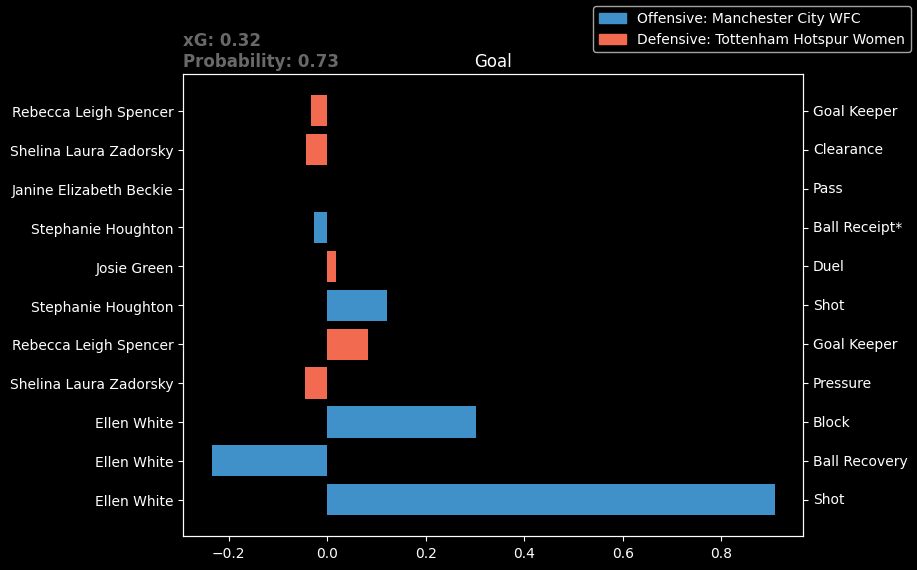

In [2]:
shap_barh_plot = models.plot_shap_barh(shap_actions_df.iloc[201])

In [3]:
shap_per_action_df = models.get_shap_per_action_df(shap_actions_df)

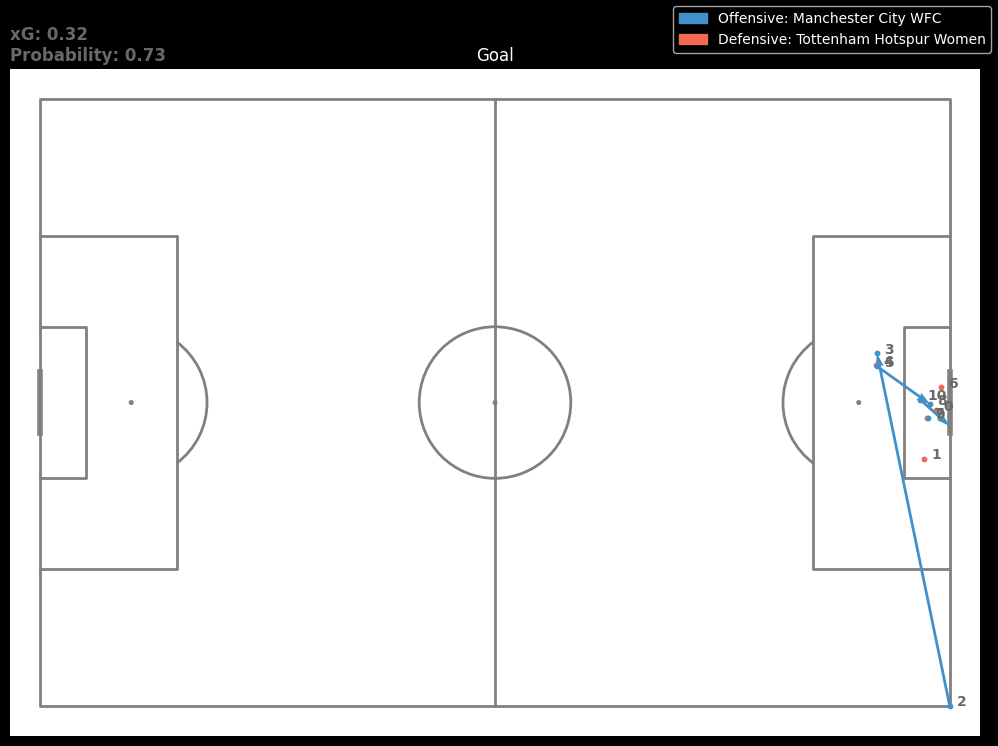

In [4]:
shap_on_pitch = models.plot_shap_on_pitch(shap_actions_df.iloc[201])

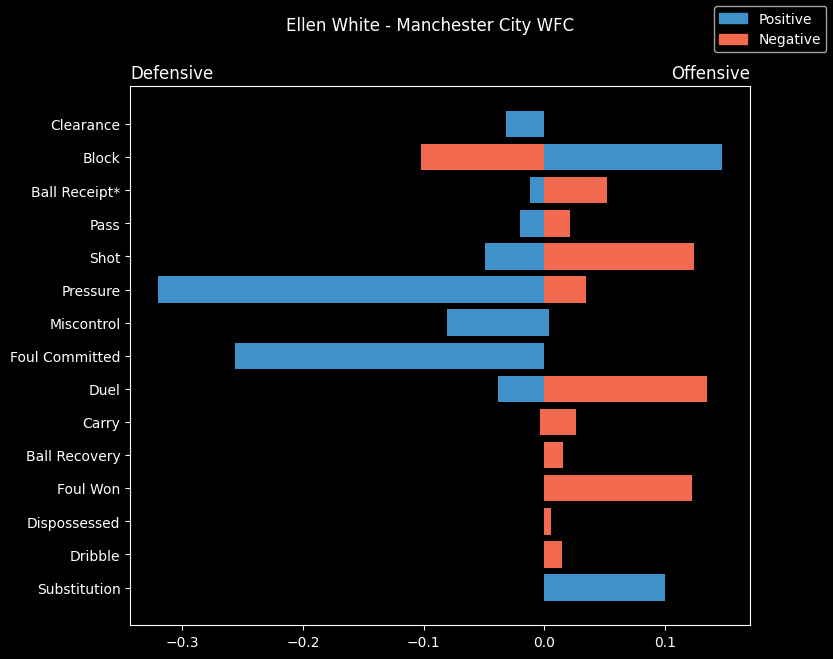

In [5]:
player_df = models.get_player_shap('Ellen White', shap_per_action_df)

player_summary = models.player_summary(player_df)

In [8]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA

df = pd.read_csv("df_1819.csv")

shap_actions_df = models.get_shap_by_action(df)
shap_per_action_df = models.getshapper
player_top_actions_df = models.get_player_top_actions(shap_per_action_df)
X_player_scaled = models.encode_standardize(player_top_actions_df)

